# `SuchLinkedTrees`

I didn't want to write this either.

### Working with linked trees

If you are interested in studying how two groups of organisms interact (or, 
rather, have interacted over evolutionary time), you will find yourself with 
two trees of distinct groups of taxa that are linked by a matrix of 
interaction observations. This is sometimes called a 'dueling trees' problem.

![dueling trees](dueling_trees.png)

If the trees happen to have the same number of taxa, and the interaction 
matrix happens to be a unit matrix, then you can compute the distance matrix
for each of your tres and use the 
[Mantel test](https://en.wikipedia.org/wiki/Mantel_test) to compare them. 
However, this is a pretty special case. Hommola *et al.* describe a method 
extends the Mantel test in this paper here :

* [A Permutation Test of Host–Parasite Cospeciation](http://dx.doi.org/10.1093/molbev/msp062). *Molecular Biology and Evolution*, Vol. 26, No. 7. (01 July 2009), pp. 1457-1468, by Kerstin Hommola, Judith E. Smith, Yang Qiu, Walter R. Gilks

In [1]:
%load_ext Cython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree
import pandas as pd
import numpy as np
import seaborn

In [ ]:
from SuchTree import SuchLinkedTrees, pearson

In [3]:
T1 = SuchTree( 'SuchTree/tests/test.tree' )
T2 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree' )
links = pd.read_csv( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_host_count_table.tsv', 
                    sep='\t', index_col='Host')
links.index = map( lambda x : x.replace(' ','_'), links.index )

### Let your trees be linked!

Now, we create a `SuchLinkedTrees` object, which connects the host and 
guest trees to the link matrix (`True` or `False` values derived from the
count matrix). This pre-indexes the table for fast access later, so creating
object takes a little while.

In [4]:
%%time
SLT = SuchLinkedTrees( T1, T2, links )

139761682196456 allocating columns in 3446384640
bulding default subset.
bulding default link list.
CPU times: user 9min 41s, sys: 2.54 s, total: 9min 43s
Wall time: 10min


### What's goodies are inside?

Let's look at how `SuchLinkedTrees` slices the link data by clade.

We'll pick a random clade...

In [5]:
SLT.TreeB.get_leafs( 7027 )

array([6936, 7040, 7046, 7052, 6880, 6938, 6940, 6942, 6994, 7028, 7034,
       7042, 7044, 7048, 7050, 7054, 7056, 6882, 6944, 6950, 6996, 6998,
       7014, 7030, 7032, 7036, 7038, 6884, 6886, 6926, 6932, 6934, 6946,
       6948, 6952, 6954, 7000, 7008, 6914, 6916, 6918, 6920, 6928, 6930,
       6972, 6986, 7002, 7010, 7012, 7016, 7024, 7026, 6888, 6890, 6892,
       6922, 6924, 6956, 6958, 6960, 6962, 6964, 6974, 6980, 6992, 7004,
       7006, 7022, 6894, 6896, 6898, 6906, 6966, 6976, 6978, 6982, 6984,
       6988, 6990, 7018, 7020, 6900, 6908, 6968, 6970, 6902, 6904, 6910,
       6912])

This one looks good.

Now, we tell our `SuchLinkedTrees` object to subset itself using that clade.

The default subset is the root node of the guest tree.

In [53]:
SLT.subset( 7027 )
print 'subset size  :', SLT.subset_size
print 'subset links :', SLT.subset_n_links
print 'link pairs   :', ( SLT.subset_n_links * ( SLT.subset_n_links -1 ) ) / 2

subset size  : 89
subset links : 245
link pairs   : 29890


print SLT.col_ids
print SLT.subset_columns
print SLT.subset_leafs

### Paired distances

We can test whether or not the guest organisms are likely to have co-diversified 
with the host organisms by computing the distances between each possible pair of
links in the link matrix through each of the two trees, and then testing how well
those two sets of distances correlate with one another.

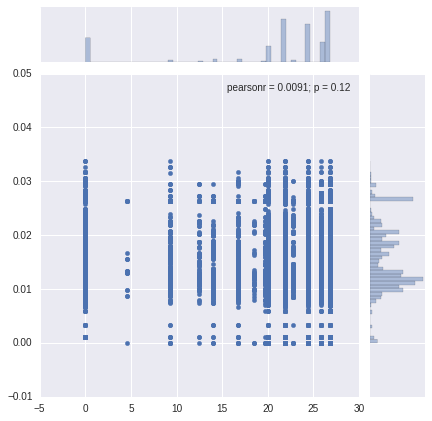

In [55]:
result = SLT.linked_distances()
seaborn.jointplot( result['TreeA'], result['TreeB'] )

Yeesh. Lousy correlation, isn't it?

Anyway, thanks to `SuchTree`, it only takes a tiny sliver of 
a second to compute the 29,890 distances through each of the two
trees.

Unfortunately, for $n$ links, the number of link pairs is

$$\frac{n (n-1)}{2}$$

This is $\mathcal{O}(n^2)$ scaling, which is $bad$. The biggest clade is 

$$ \frac{ 54327 \times 54326 }{2}= 1,475,684,301 $$

link pairs. And that's just one particularly big clade!

### Solution : sampling

We can avoid this problem (with some care) using `SuchLinkedTrees.sample_linked_distances()`.

In [42]:
result_sampled = SLT.sample_linked_distances(sigma=0.05, n=10000, buckets=10)
result_sampled

{'TreeA': array([ 26.82616806,  26.82613945,  20.02231216, ...,  26.82613754,
         26.82615089,   0.        ]),
 'TreeB': array([ 0.01804,  0.02644,  0.01492, ...,  0.0173 ,  0.0189 ,  0.01188]),
 'deviation_a': 0.04971844702959061,
 'deviation_b': 1.768802394508384e-05,
 'n_pairs': 29890,
 'n_samples': 300000}

Clade `7027` is not particularly big, so we've actually over-sampled it 
by a little more than $10\times$.

It shoudln't much different, though.

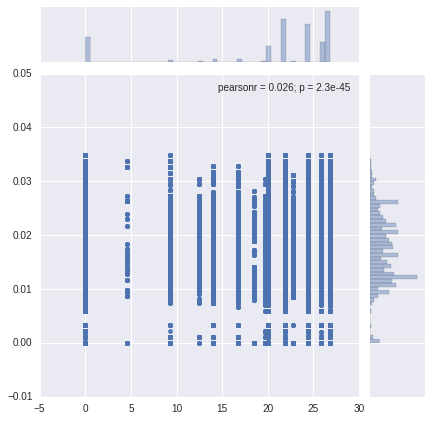

In [43]:
seaborn.jointplot( result_sampled['TreeA'], result_sampled['TreeB'] )

But, of couse, sampled distributions don't look exactly like the distributions
from which they were taken, so let's have a look at 'em.

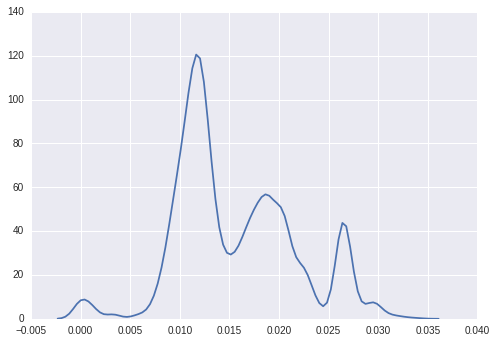

In [44]:
seaborn.kdeplot(result['TreeB'])

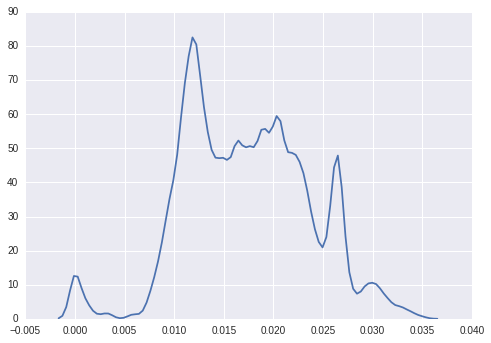

In [45]:
seaborn.kdeplot(result_sampled['TreeB'][100000:400000])

### Down to business

Now that you've seen the major features of `SuchLinkedTrees`, let's use it to do something 
useful.

How about my main dissertation question? 

*Are there any co-diversifying bacteria in my fish?*

In [46]:
import pyprind

p = pyprind.ProgBar( len( list( SLT.TreeB.get_internal_nodes() ) ), monitor=True, title='sampling trees...' )

big_nodes = []
table = {}
for n,node in enumerate( SLT.TreeB.get_internal_nodes() ) :
    p.update()
    SLT.subset( node )
    if SLT.subset_n_links > 4000 :
        big_nodes.append( node )
        result = SLT.sample_linked_distances( sigma=0.05, n=1000, buckets=100)
    else :
        result = SLT.linked_distances()
    table[node] = { 'n_leafs'    : SLT.subset_size, 
                    'n_links'    : SLT.subset_n_links,
                    'n_pairs'    : result['n_pairs'],
                    'n_samples'  : result['n_samples'],
                    'deviatnon_a': result['deviation_a'],
                    'deviation_b': result['deviation_b'],
                    'r'          : pearson( result['TreeA'], result['TreeB'] ) }

sampling trees...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 06:00:03


If exhaustively measure correlations for clades with fewer than 4000 links,
and used sampled distances for clades with more than 4000 links, it takes
about six hours on one core.

It can be threaded, but I haven't gotten around to trying that yet.

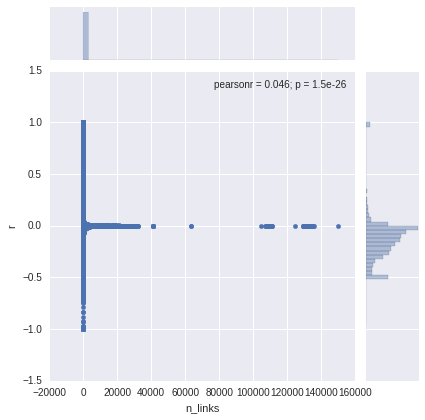

In [47]:
C = pd.DataFrame( table ).T
seaborn.jointplot( 'n_links', 'r', data=C )

Most of this is garbage. Let's focus on the good bits.

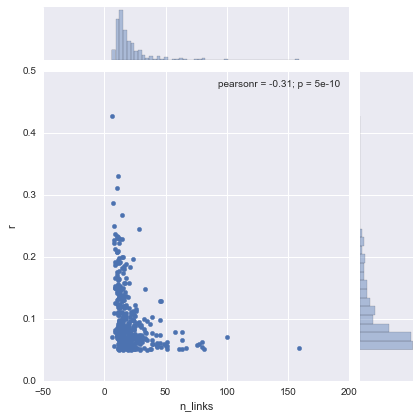

In [16]:
seaborn.jointplot( 'n_links', 'r', data=C.query('n_leafs > 5 and r > 0.05')  )

In [20]:
CC = C.query('n_leafs > 5 and r > 0.05').sort_values('r', ascending=False)
print CC.shape
CC.head()

(398, 7)


,deviation_b,deviatnon_a,n_leafs,n_links,n_pairs,n_samples,r
98839,NaN,NaN,6.0,6.0,15.0,15.0,0.426846
88617,NaN,NaN,7.0,11.0,55.0,55.0,0.330649
79047,NaN,NaN,6.0,10.0,45.0,45.0,0.310790
47385,NaN,NaN,6.0,7.0,21.0,21.0,0.286141
10121,NaN,NaN,8.0,14.0,91.0,91.0,0.267268


## Correlation smorrilation

Well, the only reason I'm using Pearson's $r$ is because it happens to be an 
$\mathcal{O}(n)$ algorithm. It also assumes that the distributions of the 
things you are testing are normal.

We already saw that they are *not* normal.

We really should use a rank-order correlation test like Kendall's $\tau$ 
because they don't make any assumptions about the distributions, but
these are all $\mathcal{O}(n^2)$ algorithms.

Once again, the massive diversity of microbes forces us to really sweat the
details.

So, let's just use Pearson's $r$ to out what the correlations *probably* 
are, and then find Kendall's $\tau$ for the ones that look interesting.

In [35]:
from scipy.stats import kendalltau, pearsonr

pearson_p   = {}
kendall_tau = {}
kendall_p   = {}

for n,node in enumerate( CC.index ) :
    SLT.subset(node)
    result = SLT.linked_distances()
    p_r,p_p = pearsonr(   result['TreeA'], result['TreeB'] )
    k_t,k_p = kendalltau( result['TreeA'], result['TreeB'] )
    pearson_p[node]  = p_p
    kendall_tau[node] = k_t
    kendall_p[node]   = k_p

CC['pearson_p'] = pd.Series(pearson_p)
CC['kendall_tau'] = pd.Series(kendall_tau)
CC['kendall_p'] = pd.Series(kendall_p)
CC.head()

,deviation_b,deviatnon_a,n_leafs,n_links,n_pairs,n_samples,r,pearson_p,kendall_tau,kendall_p
98839,NaN,NaN,6.0,6.0,15.0,15.0,0.426846,0.112563,0.394082,0.040588
88617,NaN,NaN,7.0,11.0,55.0,55.0,0.330649,0.013678,0.365082,0.000083
79047,NaN,NaN,6.0,10.0,45.0,45.0,0.310790,0.037714,0.211630,0.040410
47385,NaN,NaN,6.0,7.0,21.0,21.0,0.286141,0.208586,0.174698,0.267937
10121,NaN,NaN,8.0,14.0,91.0,91.0,0.267268,0.010434,0.076982,0.279817


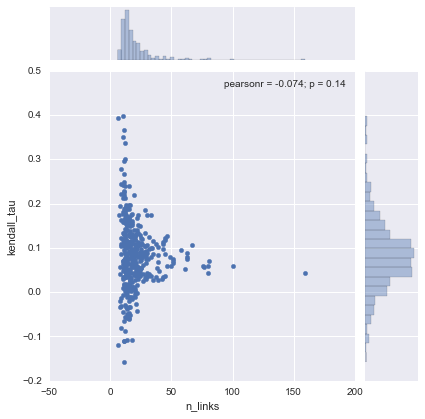

In [36]:
seaborn.jointplot( 'n_links', 'kendall_tau', data=CC )

## The Moment of Truth

Well, there's one clade up there that has a $\tau$ of 0.394 with a $p$ of 0.040588.

Could this be... it?

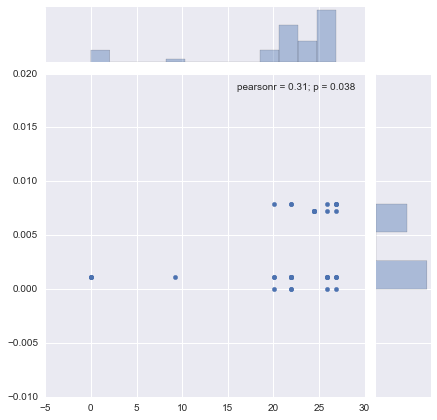

In [40]:
SLT.subset( 79047 )
result = SLT.linked_distances()
seaborn.jointplot( result['TreeA'], result['TreeB'] )

## Verdict : Meh.

Does't look very convincing to me.